In [2]:
using ReinforcementLearning
using Plots
using Statistics
using StatsPlots
using Flux

In [3]:
env = MultiArmBanditsEnv()

# MultiArmBanditsEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |       TerminalReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |   Observation{Int64}() |
| DefaultStateStyle |   Observation{Int64}() |
| EpisodeStyle      |             Episodic() |

## Is Environment Terminated?

No

## State Space

`Base.OneTo(1)`

## Action Space

`Base.OneTo(10)`

## Current State

```
1
```


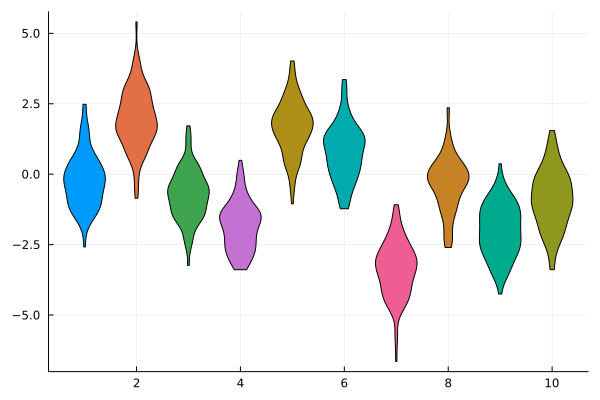

In [4]:
violin(
    [
        [
            begin 
                reset!(env)
                act!(env, a)  # Correct function to take action
                reward(env)
            end
            for _ in 1:100
        ]
        for a in action_space(env)
    ],
    leg=false
)

In [5]:
"""
A customized hook to record whether the action to take is the best action or not.
"""
begin
	Base.@kwdef struct CollectBestActions <: AbstractHook
		best_action::Int
		isbest::Vector{Bool} = []
	end

	function (h::CollectBestActions)(::PreActStage, agent, env, action)
		push!(h.isbest, h.best_action==action)
	end
end

In [24]:
TabularQApproximator(
				   n_state=length(state_space(env)),
				   n_action=length(action_space(env)),
				   init=0.,
				#    opt = InvDecay(1.0)
			   )

::TabularApproximator	
└─ model::Array => [0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;]	


In [25]:
function bandit_testbed(
	;explorer=EpsilonGreedyExplorer(0.1),
	true_reward=0.0,
	init=0.,
	opt=InvDecay(1.0)
)
   env = MultiArmBanditsEnv(;true_reward=true_reward)
   agent = Agent(
	   policy=QBasedPolicy(
		   learner = MonteCarloLearner(
			   approximator = TabularQApproximator(
				   n_state=length(state_space(env)),
				   n_action=length(action_space(env)),
				   init=init,
				#    opt = opt
			   ),
			   γ = 1.0
		   ),
		   explorer = explorer
	   ),
	   trajectory=VectorSARTTrajectory()
	)
	h1 = CollectBestActions(;best_action=findmax(env.true_values)[2])
	h2 = TotalRewardPerEpisode(;is_display_on_exit=false)
	run(agent, env, StopAfterStep(1000), ComposedHook(h1, h2))
    h1.isbest, h2.rewards
end

bandit_testbed (generic function with 1 method)

In [26]:
bandit_testbed()

LoadError: UndefVarError: `MonteCarloLearner` not defined

In [9]:
begin
	p = plot(layout=(2, 1))
	for ϵ in [0.1, 0.01, 0.0]
    	stats = [
			bandit_testbed(;explorer=EpsilonGreedyExplorer(ϵ))
			for _ in 1:2000
		]
    	plot!(p, mean(x[2] for x in stats);
			subplot=1, legend=:bottomright, label="epsilon=$ϵ")
    	plot!(p, mean(x[1] for x in stats);
			subplot=2, legend=:bottomright, label="epsilon=$ϵ")
	end
	p
end

LoadError: MethodError: no method matching TabularApproximator(; table::Dict{Any, Any}, optimizer::InvDecay)

[0mClosest candidates are:
[0m  TabularApproximator([91m::A[39m) where A<:AbstractArray[91m got unsupported keyword arguments "table", "optimizer"[39m
[0m[90m   @[39m [36mReinforcementLearningCore[39m [90mC:\Users\joses\.julia\packages\ReinforcementLearningCore\jIECU\src\policies\learners\[39m[90m[4mtabular_approximator.jl:19[24m[39m
[0m  TabularApproximator([91m::A[39m) where A[91m got unsupported keyword arguments "table", "optimizer"[39m
[0m[90m   @[39m [36mReinforcementLearningCore[39m [90mC:\Users\joses\.julia\packages\ReinforcementLearningCore\jIECU\src\policies\learners\[39m[90m[4mtabular_approximator.jl:4[24m[39m
